# PROJET PYTHON 

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [4]:
erp = pd.read_excel('erp.xlsx')
liaison = pd.read_excel('liaison.xlsx')
web = pd.read_excel('web.xlsx')


In [5]:
print("les dimensions des datasets sont :\n\nerp : {}\nliason : {}\nweb : {}".format(erp.shape,liaison.shape, web.shape),
     "\n\nles colonnes des datasets sont :\n\nerp : {}\nliason:{}\nweb : {}".format(erp.columns,liaison.columns, web.columns))

les dimensions des datasets sont :

erp : (825, 5)
liason : (825, 2)
web : (1513, 28) 

les colonnes des datasets sont :

erp : Index(['product_id', 'onsale_web', 'price', 'stock_quantity', 'stock_status'], dtype='object')
liason:Index(['product_id', 'id_web'], dtype='object')
web : Index(['sku', 'virtual', 'downloadable', 'rating_count', 'average_rating',
       'total_sales', 'tax_status', 'tax_class', 'post_author', 'post_date',
       'post_date_gmt', 'post_content', 'post_title', 'post_excerpt',
       'post_status', 'comment_status', 'ping_status', 'post_password',
       'post_name', 'post_modified', 'post_modified_gmt',
       'post_content_filtered', 'post_parent', 'guid', 'menu_order',
       'post_type', 'post_mime_type', 'comment_count'],
      dtype='object')


In [6]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [7]:
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [8]:
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0


### ANALYSES ET NETTOYAGE DES DONNEES ET JOINTURE DES DATASETS:

On va dans un premier temps s'occuper des valeurs manquantes afin de faire le merge les datasets.
On se rend compte dans un premier temps que le dataset erp n'a pas de valeurs manquantes et que le dataset liaison a 91 Nan dans la colonne id_web. Les product_id correspondant n'ont pas fait de ventes en ligne donc on peut également les supprimer du dataset. 

In [9]:
print(erp.isna().sum(),'\n')   # 0 Nan -> Ok 
print(liaison.isna().sum())    # 91 Nan dans liaison.id_web --> on les supprime 
liaison.dropna(inplace=True)
print("liaison shape : {}".format(liaison.shape))

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64 

product_id     0
id_web        91
dtype: int64
liaison shape : (734, 2)


En regardant les valeurs de la colonne sku du dataset web on se rend compte que 
chaque ligne du dataset correspondant à une valeur dans sku est en double avec seulement quelques changements 
dans des colonnes qui n'ont pas d'utilités ici (i.e tax_status, post_type ou post_mime_type). On peut ainsi diviser la taille du dataset par 2 en ne gardant que les valeurs uniques de la colonne sku. 

In [10]:
print(web.sku.value_counts(dropna=False))

web.sku.drop_duplicates().index                  #on recupère les index des valeurs uniques
web = web.iloc[web.sku.drop_duplicates().index]  # on récupère le dataset web avec les index des valeurs uniques

#on refait un point sur les dimensions:
print("les dimensions des datasets sont maintenant :\nerp : {}\nliason : {}\nweb : {}"
      .format(erp.shape,liaison.shape, web.shape))

NaN        85
14827.0     2
15526.0     2
16305.0     2
16306.0     2
           ..
15145.0     2
15801.0     2
15452.0     2
15038.0     2
16230.0     2
Name: sku, Length: 715, dtype: int64
les dimensions des datasets sont maintenant :
erp : (825, 5)
liason : (734, 2)
web : (715, 28)


Maintenant on va pouvoir faire le merge des datasets 
afin d'obtenir un dataset contenant toutes les informations nécessaires

In [11]:
# join les datasets liaison et erp via product_id
erp_liaison = pd.merge(liaison,erp, left_on='product_id',right_on='product_id', how='inner')

# merge le dataset erp_liaison avec le dataset web en indiquant que sku dans le dataset web correspond 
# à id_web dans le dataset erp_liaison
df_total = pd.merge(erp_liaison, web, how='inner', left_on='id_web',right_on='sku')

In [12]:
df_total.head()

,product_id,id_web,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,3847,15298,1,24.2,0,outofstock,15298,0,0,0,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
1,3849,15296,1,34.3,0,outofstock,15296,0,0,0,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
2,3850,15300,1,20.8,0,outofstock,15300,0,0,0,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
3,4032,19814,1,14.1,0,outofstock,19814,0,0,0,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
4,4039,19815,1,46.0,0,outofstock,19815,0,0,0,...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0


Petit point sur les dimensions et valeurs du dataset total.

Nous avons des valeurs manquantes ou nulles seulement dans des colonnes dont nous n'avons pas d'utilité ici.

In [13]:
print(df_total.isna().sum(), df_total.shape)

product_id                 0
id_web                     0
onsale_web                 0
price                      0
stock_quantity             0
stock_status               0
sku                        0
virtual                    0
downloadable               0
rating_count               0
average_rating             0
total_sales                0
tax_status                 0
tax_class                714
post_author                0
post_date                  0
post_date_gmt              0
post_content             714
post_title                 0
post_excerpt               0
post_status                0
comment_status             0
ping_status                0
post_password            714
post_name                  0
post_modified              0
post_modified_gmt          0
post_content_filtered    714
post_parent                0
guid                       0
menu_order                 0
post_type                  0
post_mime_type           714
comment_count              0
dtype: int64 (

Regardons le chiffre d'affaire que ce marchand de vins a effectué

In [14]:

df_total.dtypes  # onsale_web, total_sales et price sont deja des nombres (float ou int) donc il n'y a rien 
                 # à modifier 

df_total['CA_par_produit_online'] = df_total.onsale_web*df_total.price
print("Le CA par produit vendu en ligne est de :\n{}"                     # Note that this is before taxes! 
      .format(df_total.CA_par_produit_online.sort_values(ascending=False)))
print("Le Chiffre d'Affaire réalisé en ligne est de : {} euros".format(df_total['CA_par_produit_online'].sum()))

print("Le Chiffre d'Affaire total réalisé est de : {} euros".format((df_total.total_sales*df_total.price).sum()))

Le CA par produit vendu en ligne est de :
199    225.0
426    217.5
587    191.3
218    176.0
553    175.0
       ...  
98       5.7
99       5.7
97       5.7
560      5.7
645      5.2
Name: CA_par_produit_online, Length: 714, dtype: float64
Le Chiffre d'Affaire réalisé en ligne est de : 23200.1 euros
Le Chiffre d'Affaire total réalisé est de : 70568.6 euros


### ANALYSES STATISTIQUES :



In [15]:
df_total.T

,0,1,2,3,4,5,6,7,8,9,...,704,705,706,707,708,709,710,711,712,713
product_id,3847,3849,3850,4032,4039,4040,4041,4042,4043,4045,...,6886,6887,6920,6926,6928,6930,7023,7025,7247,7338
id_web,15298,15296,15300,19814,19815,15303,14975,16042,14980,16041,...,14897,15736,15740,15845,15741,16135,15891,15887,13127-1,16230
onsale_web,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
price,24.2,34.3,20.8,14.1,46.0,34.3,32.7,31.2,60.0,42.6,...,42.0,21.8,50.5,49.9,19.0,8.4,27.5,69.0,54.8,16.3
stock_quantity,0,0,0,0,0,0,15,34,12,66,...,0,24,1,24,20,83,15,2,23,45
stock_status,outofstock,outofstock,outofstock,outofstock,outofstock,outofstock,instock,instock,instock,instock,...,outofstock,instock,instock,instock,instock,instock,instock,instock,instock,instock
sku,15298,15296,15300,19814,19815,15303,14975,16042,14980,16041,...,14897,15736,15740,15845,15741,16135,15891,15887,13127-1,16230
virtual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
downloadable,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rating_count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


on voit que la quasi totalité des colonnes ne nous intéressent pas.
On peut donc commencer par garder seulement les colonnes qui nous seront utiles : 'onsale_web', 'stock_quantity','total_sales' et 'price'

In [16]:
df = df_total.copy()
df = df[['onsale_web', 'stock_quantity','total_sales','price']]

#### METHODE DES INTERQUARTILES

In [17]:
X = df[['onsale_web', 'stock_quantity','total_sales']]
y = df.price

print("Description de X\n",X.describe())

Q1 = X.describe().values[4,:]
Q3 = X.describe().values[6,:]

print("Quartile 1 : {}" .format(Q1),
     "\nQuartile 3 : {}".format(Q3))
EQX = []
for i in range(Q1.size):
    EQX.append(Q3[i]-Q1[i])
    
print("Les équarts interquartiles du DataFrame X sont de :", EQX)
    
print("\nDescription de y\n",y.describe())
EQy = y.describe().values[6] - y.describe().values[4]
print("Les quartiles du vecteur y sont : \nQ1 = {},\nQ3 = {}".format(y.describe().values[4],y.describe().values[6])
      ,"\nL'écart inter quartile du vecteur y est de : ",EQy)
print("\nNombre de valeures comprises entre les deux quartiles :\n",
      y[(y>=y.describe().values[4]) & (y<=y.describe().values[6])].count())

Description de X
        onsale_web  stock_quantity  total_sales
count       714.0      714.000000   714.000000
mean          1.0       28.746499     4.012605
std           0.0       48.012608     8.518183
min           1.0        0.000000     0.000000
25%           1.0        2.000000     0.000000
50%           1.0       12.000000     1.000000
75%           1.0       35.000000     4.000000
max           1.0      578.000000    96.000000
Quartile 1 : [1. 2. 0.] 
Quartile 3 : [ 1. 35.  4.]
Les équarts interquartiles du DataFrame X sont de : [0.0, 33.0, 4.0]

Description de y
 count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64
Les quartiles du vecteur y sont : 
Q1 = 14.1,
Q3 = 42.175000000000004 
L'écart inter quartile du vecteur y est de :  28.075000000000003

Nombre de valeures comprises entre les deux quartiles :
 357


Pour le vecteur y on trouve 179 valeurs de prix au dessus du 3ème quartile, 178 valeurs inférieures au 1er quartile et
357 valeurs comprises entre les deux quartiles. On voit que la répartition des valeurs est assez symétrique. Cependant 
on remarque que la différence entre les valeurs maximales et le quartile 3 sont bien plus grande que les différences 
entre les valeurs minimales et le quartile 1. On appuiera ainsi nos analyses statistiques autour des valeurs maximales 
pour trouver les outliers s'il y en a.

#### METHODE DU Z-SCORE : 

In [18]:
# z score du vecteur prix y 

std_price = np.std(y)
zscore_price = stats.zscore(y)

In [19]:
print("std : ",std_price)
print("zscore :\n",zscore_price)

std :  27.791042941002935
zscore :
 0     -0.298410
1      0.065016
2     -0.420752
3     -0.661837
4      0.486015
         ...   
709   -0.866939
710   -0.179667
711    1.313620
712    0.802664
713   -0.582675
Name: price, Length: 714, dtype: float64


In [20]:
# pour le premier élément, nous avons un zscore = -2.98410437e-01 ce qui signifie que cet élément est à 
#environ -0.3 #de la moyenne.

# On récupère les indices
result_1 = []
for element in zscore_price:
    if abs(element) > 2:
        result_1.append(zscore_price[zscore_price==element].index[0])

In [21]:
# En utilisant les index ci dessus, on obtient les prix des outliers : 
# les prix dont le z score à une valeur supérieure à 2
for i in result_1:
    print(y[i],'€')

100.0 €
88.4 €
225.0 €
126.5 €
176.0 €
108.5 €
157.0 €
104.0 €
109.6 €
102.3 €
137.0 €
217.5 €
105.0 €
105.0 €
112.0 €
92.0 €
124.8 €
175.0 €
191.3 €
93.0 €
122.0 €
114.0 €
135.0 €
105.6 €
116.4 €
115.0 €
121.0 €
99.0 €
115.0 €
121.0 €


### METHODE GRAPHIQUE:
     

#### BOXPLOT 

Text(0.5, 0, 'price')

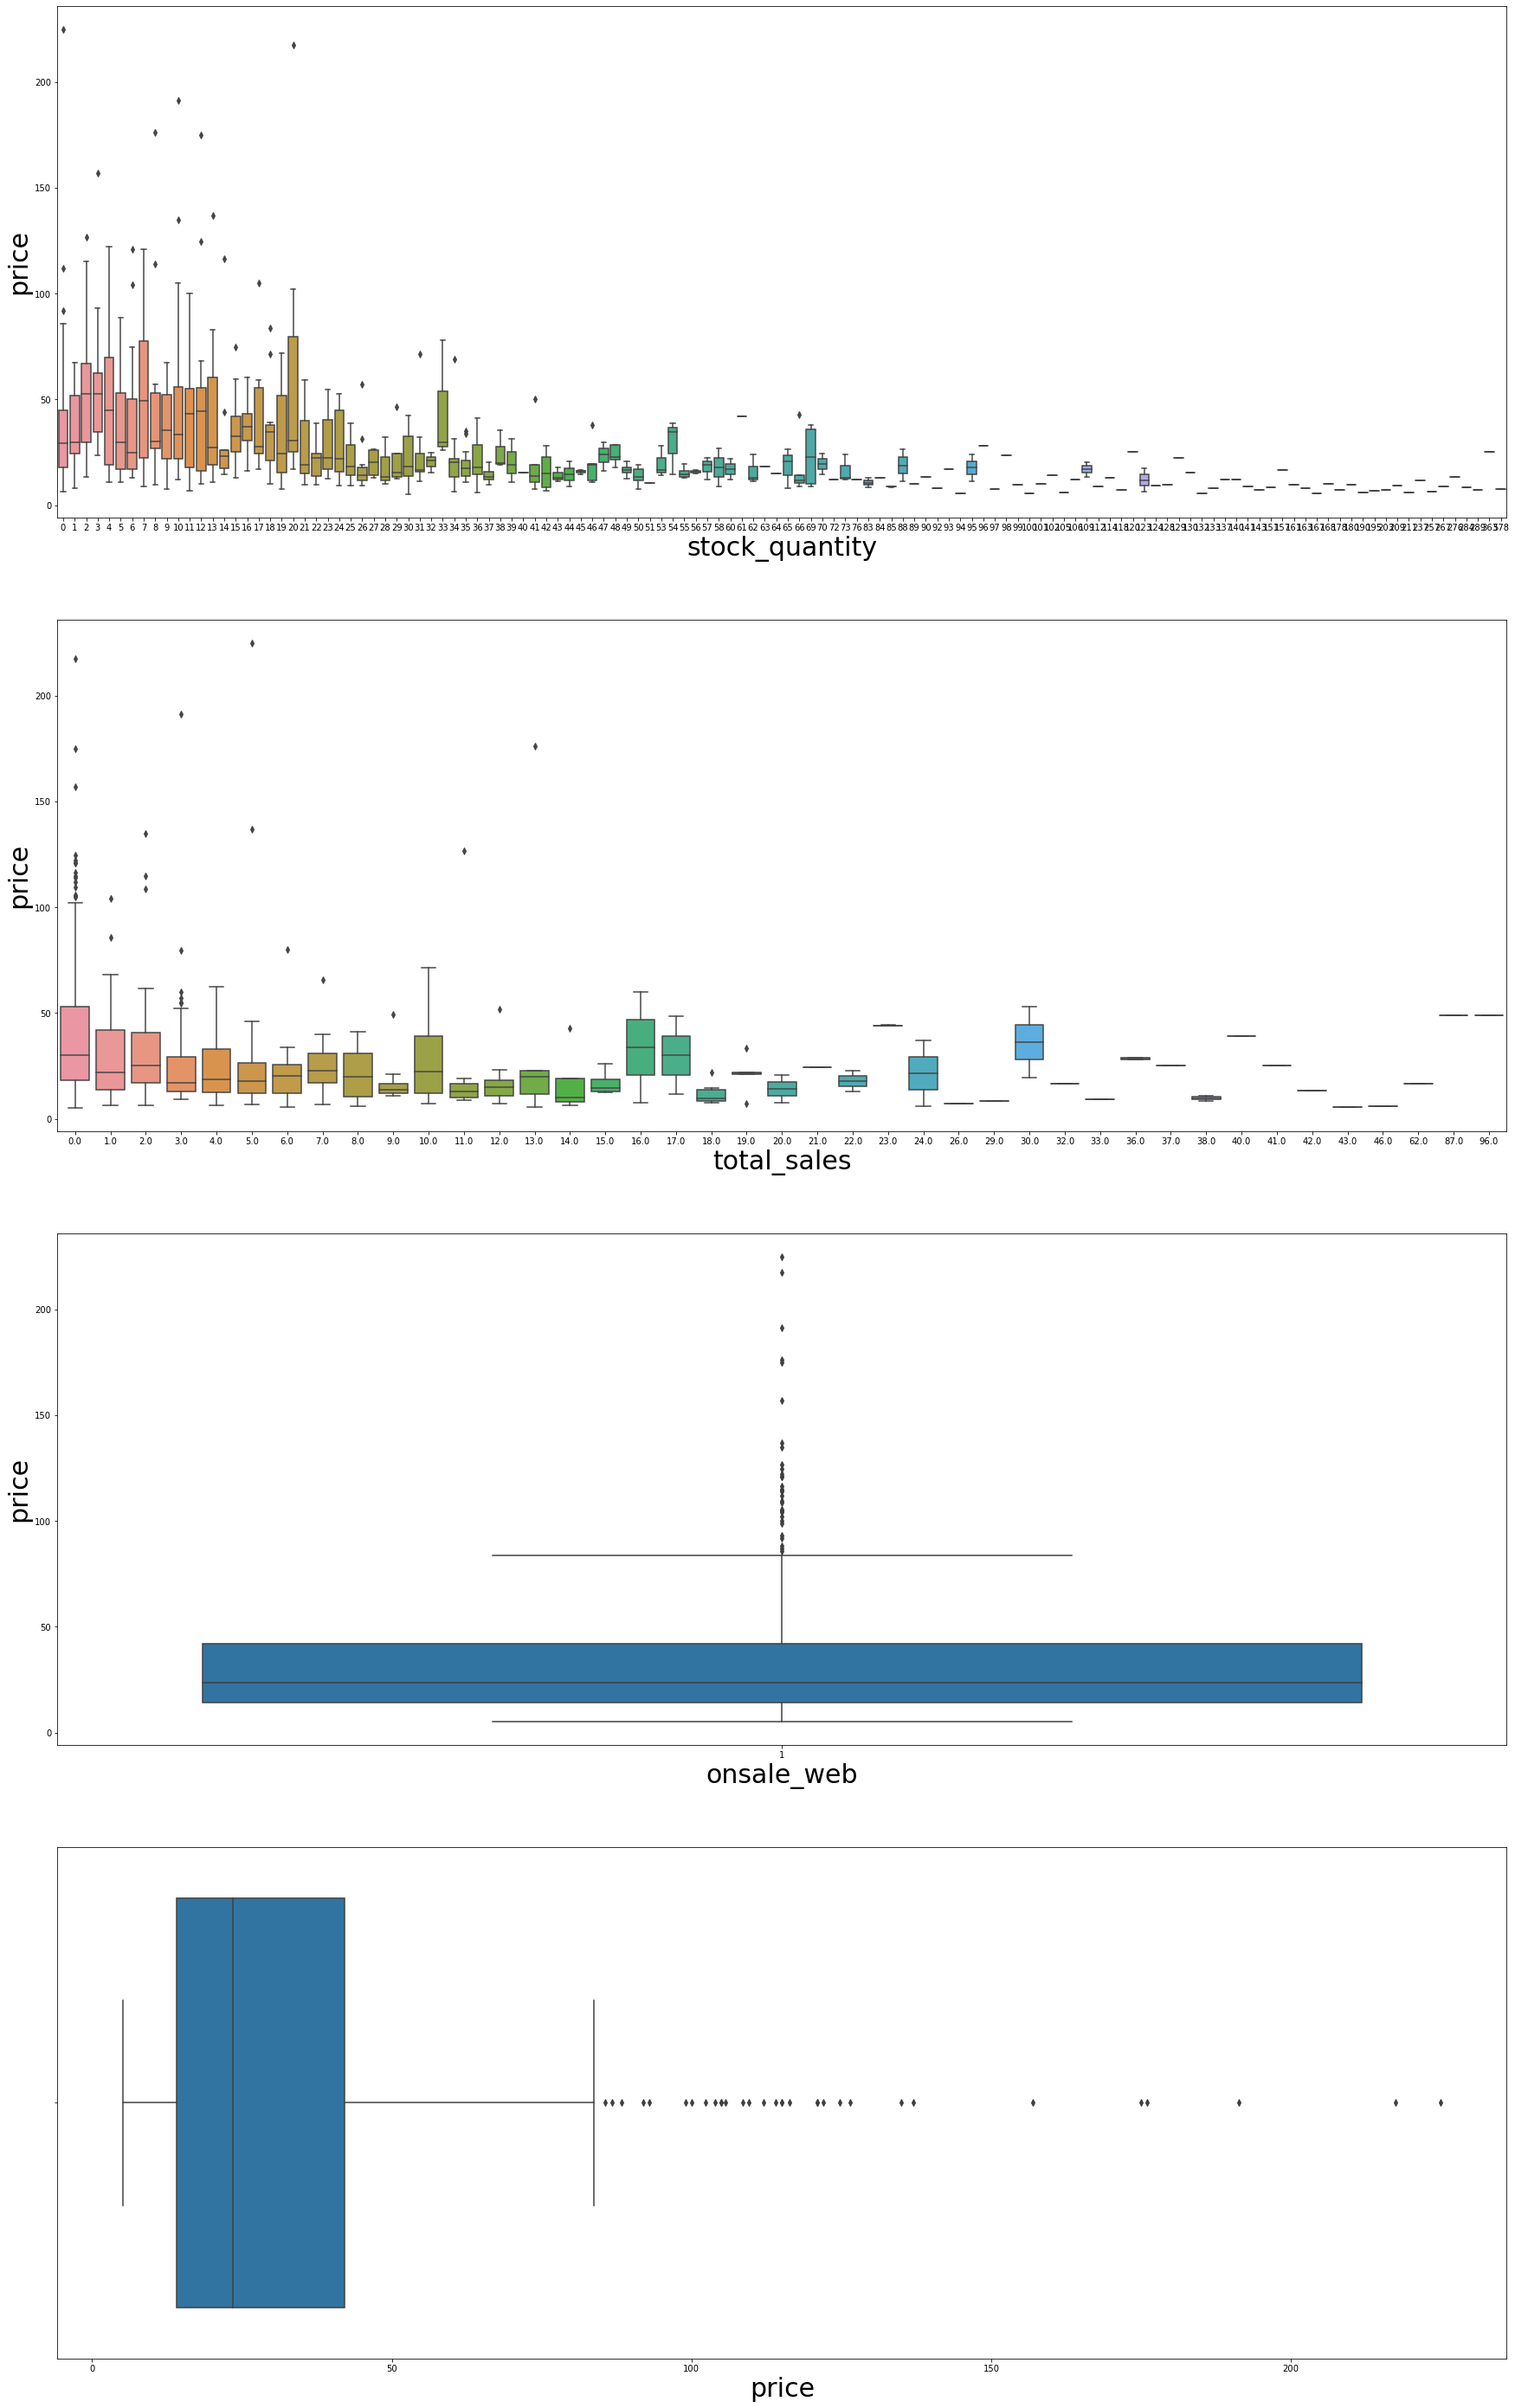

In [35]:
plt.figure(figsize=(30,50))
plt.subplot(4,1,1)
a = sns.boxplot( y=df["price"], x=df["stock_quantity"]);
a.set_xlabel('stock_quantity',fontsize=30)
a.set_ylabel('price', fontsize=30)

plt.subplot(4,1,2)
b = sns.boxplot( y=df["price"], x=df["total_sales"]);
b.set_xlabel('total_sales',fontsize=30)
b.set_ylabel('price', fontsize=30)

plt.subplot(4,1,3)
c = sns.boxplot( y=df["price"], x=df["onsale_web"]);
c.set_xlabel('onsale_web',fontsize=30)
c.set_ylabel('price', fontsize=30)

plt.subplot(4,1,4)
d = sns.boxplot(y)
d.set_xlabel('price', fontsize=30)



#### Analyse:

Sur les Figures 1 et 2 (stock_quantity en fonction du prix et total_sales en fonction du prix): on voit que les produits avec un prix supérieur à 80€ sont moins vendus et ont un stock faible. Quant au produit moins chers (ayant un prix inférieur à 50€) on remarque que certains se vendent très bien et que d'autres se vendent peu.

Sur les Figures 3 et 4 (onsale web en fonction du prix) on remarque que les produits les plus vendus sur le web sont ceux avec un prix inférieur à 50


#### NUAGES DE POINTS 

Text(0.5, 0, 'onsale web')

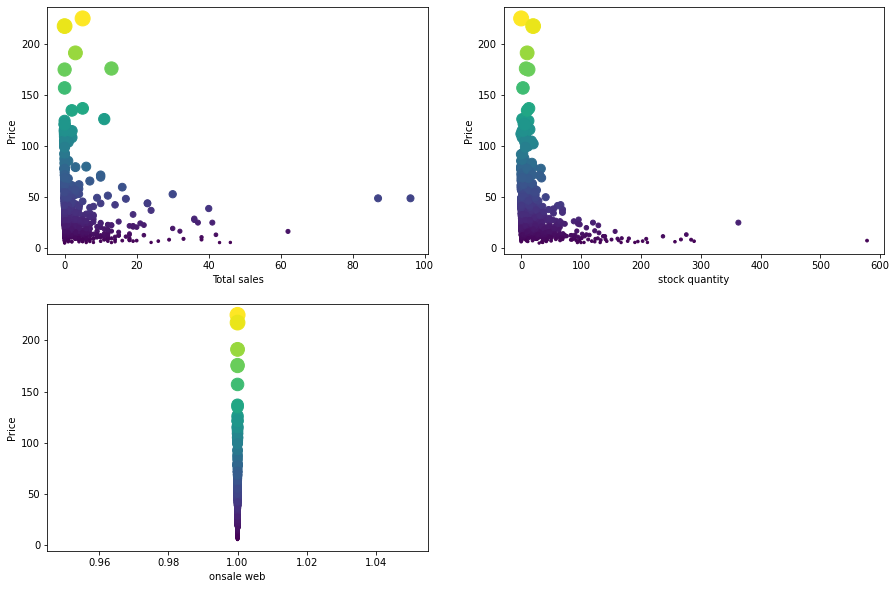

In [36]:
#nuage de points 
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(data=df , y='price', x='total_sales', s='price', c='price')
plt.ylabel("Price")
plt.xlabel("Total sales")

plt.subplot(2,2,2)
plt.scatter(data=df , y='price', x='stock_quantity', s='price', c='price')
plt.ylabel("Price")
plt.xlabel("stock quantity")

plt.subplot(2,2,3)
plt.scatter(data=df , y='price', x='onsale_web', s='price', c='price')
plt.ylabel("Price")
plt.xlabel("onsale web")

De la même manière qu'avec les boxplots on remarque que les produits les plus chers sont les moins vendus 
et ceux avec un stock le plus faible. On voit cependant mieux sur ces graphiques les produits dont 
le nombre de ventes est très grands.

### REGRESSION LINEAIRE 

In [37]:
def linear_model(X,y):
    lm = LinearRegression()
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=7)
    n_train = y_train.shape[0]
    n_val = y_test.shape[0]
    n_test = y_test.shape[0]
    print("total_train observations : %s" % n_train)
    print("total_test observations : %s" % n_test)
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    lm.fit(X_train,y_train)
    train_pred = lm.predict(X_train)
    test_pred = lm.predict(X_test)
    score = [r2_score(y_train,train_pred), r2_score(y_test,test_pred)]
    return score

In [38]:
score = linear_model(X,y)
print("R2 score sur le  training dataset : %s" % score[0])
print("R2 score sur le test dataset : %s" % score[1])

total_train observations : 535
total_test observations : 179
R2 score sur le  training dataset : 0.08346730839278471
R2 score sur le test dataset : 0.10058133229881971


### BONUS 1: CONSTRUCTION DE PROFIL A L'AIDE DES K-MEANS 

0.6064653410348375


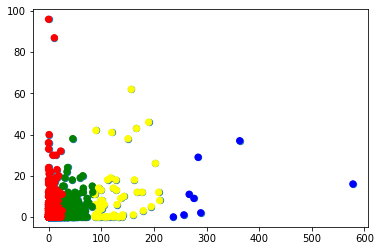

In [39]:
#Cluster K-means
km=KMeans(n_clusters=4)
#adapter le modèle de données
km.fit_predict(X)
print(silhouette_score(X, km.labels_)) 

colormap=np.array(['Red','green','blue','yellow','orange'])
plt.scatter(X.stock_quantity, X.total_sales,s=40)
plt.scatter(X.stock_quantity, X.total_sales,c=colormap[km.labels_],s=40)

Grâce à la méthode k_means nous avons pu construire des clusters. Etant donnée qu'on ne connait pas le nombre de clusters optimal, nous avons choisi un nombre de 4. Nos données sont donc divisées en 4 clusters de couleurs différentes.
Dans la partie qui va suivre, le but sera justement de déterminer le nombre optimal de clusters afin d'avoir une représentation significative.

### BONUS 2 : OPTIMISATION DU NOMBRE DE CLUSTERS

#### METHODE ELBOW 

In [40]:
!pip install yellowbrick

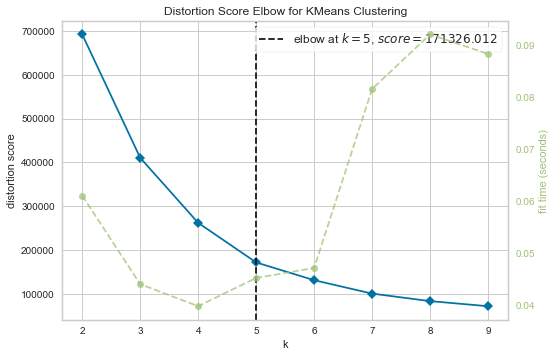

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(km, k=(2,10), timings= True)
# Fit data to visualizer
visualizer.fit(X)       
visualizer.show()


0.6041175076898337


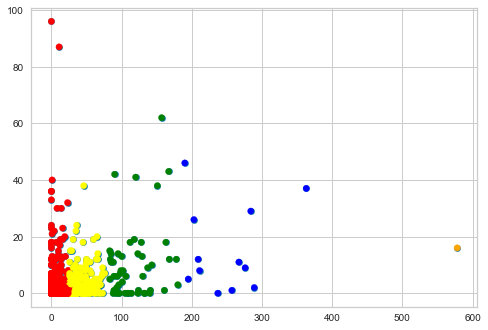

In [42]:
#Cluster K-means
km=KMeans(n_clusters=5)
#adapter le modèle de données
km.fit_predict(X)
print(silhouette_score(X, km.labels_)) 

colormap=np.array(['Red','green','blue','yellow','orange'])
plt.scatter(X.stock_quantity, X.total_sales,s=40)
plt.scatter(X.stock_quantity, X.total_sales,c=colormap[km.labels_],s=40)

Grace à la méthode Elbow, on voit que le nombre de cluster optimal est de 5. 